Loads DEM, coherence maps. <br>
Select pixels based on the following criteria:
1. in a certain elevation range (not too low = in LS, not too high = affected by atm noise)
2. spent X fraction of time spent above X threshold coherence value.
3. above threshold of average coherence (temporal)
4. below threshold of coherence standard deviation (temporal)

Thresholds for smaller cropped area: 
1. Between -20 and 75 m elevation
2. Spends 80% of time with coherence above 0.8
3. has avg coherence above 0.88
4. has coherence std below 0.1

Thresholds for larger cropped area **including western mtns**: 
1. Between -20 and 75 m elevation
2. Spends 80% of time with coherence above 0.8
3. has avg coherence above 0.88
4. has coherence std below 0.1
5. has average TPC below XXX threshold 

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load the DEM.

In [2]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'

# size of full res SLCs (same as DEM)
dxIN=18000
dyIN=3600

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)

print('DEM loaded.')

DEM loaded.


Create DEM/elevation-based mask.

pixels satisfying elevation criteria assigned as 1s.


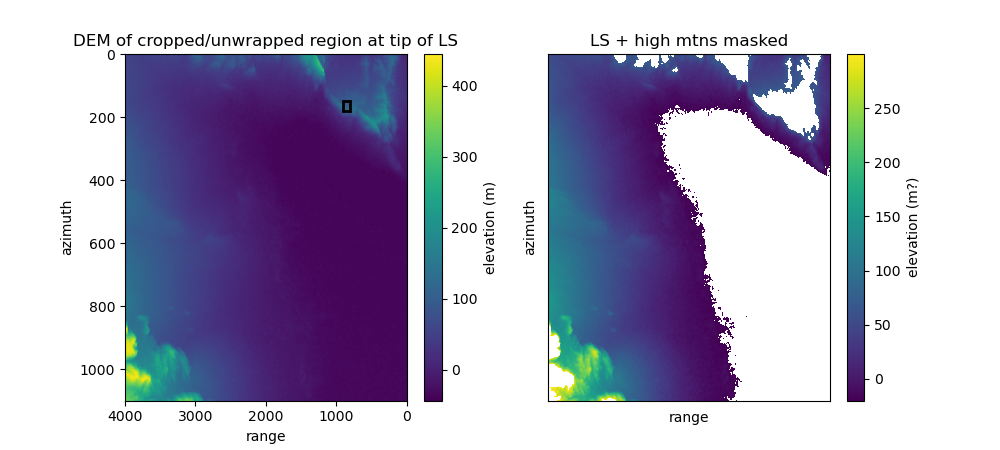

In [3]:
# Extract subregion that was unwrapped full res and plot it. 
box = np.zeros((5,2))
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000
# larger box with western mtns
x1 = 18000
y1 = 2100

box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]; box[4] = box[0]
elev_cropped = elev[y2:y1,x2:x1]

# small cropped area 
# elev_masked_LS = np.ma.masked_where(elev_cropped<-20,elev_cropped)
# elev_masked_mtns = np.ma.masked_where(elev_cropped>75,elev_cropped)

# For LARGER cropped area with western mountains, we need different criteria for opposite mtns. 
dy = y1-y2; dx = x1-x2
elev_ref_region = np.zeros((dy,dx))
for y in range(dy):
    for x in range(dx):
        if (x*-0.275+1100 > y) : # top right geographically 
            if (elev_cropped[y,x] > -20) and (elev_cropped[y,x] < 75):
                elev_ref_region[y,x] = 1.0
        else: # bottom left geographically 
            if (elev_cropped[y,x] > -20) and (elev_cropped[y,x] < 300): #300 
                elev_ref_region[y,x] = 1.0
print('pixels satisfying elevation criteria assigned as 1s.')
# larger area with western mtns 
elev_masked = np.ma.masked_where(elev_ref_region==0,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_cropped, cmap='viridis',aspect='auto',interpolation='none')
plt.xlim(x1-x2, 0)
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('DEM of cropped/unwrapped region at tip of LS')
plt.colorbar(label='elevation (m)')
plt.subplot(1,2,2)
plt.imshow(elev_masked, cmap='viridis',aspect='auto',interpolation='none'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS + high mtns masked'); plt.colorbar(label='elevation (m?)')
plt.show()

Load coherence maps.

In [4]:
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# dx = 3000
# dy = 750
dx = x1-x2
dy = y1-y2

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'-'+str(date2)+'.r4' # CHECK FOR - or _ in names
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')

Coh maps loaded.


Calculate how much time each pixel has spend above threshold value. 

In [5]:
# set threshold values 
th_coh  = 0.8
th_time = 0.75  # 80% of the time 

time_above_th = np.ndarray((dy,dx),dtype='float')
for y in range(dy):         # dy
    for x in range(dx):     # dx
        coh_temp = coh[:,y,x]
        time_above_th[y,x] = (coh_temp>=th_coh).sum()
time_above_th = time_above_th/numIgrams # converts to percentage of dates 
print('Num dates above '+str(th_coh)+' coh threshold calculated.')

Num dates above 0.8 coh threshold calculated.


Now calculate coherence standard deviation and mean for each pixel over time.

In [6]:
# initialize arrays for means and stds
coh_mean = np.ndarray((dy,dx),dtype='float')
coh_std = np.ndarray((dy,dx),dtype='float')
for y in range(dy):         # dy
    for x in range(dx):     # dx
        coh_temp = coh[:,y,x]
        coh_mean[y,x] = np.median(coh_temp)
        coh_std[y,x] = np.std(coh_temp)
print('Coh means and standard deviations calculated.')

Coh means and standard deviations calculated.


Save the avg coh and std coh maps for the larger section that includes western mtns.

In [11]:
# only do this once
# skip next time 
%%script echo skipping

saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'
fileName = 'coh_avg.r4'
fileName2 = 'coh_std.r4'
driver=gdal.GetDriverByName('ISCE')

colds = driver.Create(saveDir+fileName,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(coh_mean)
colds=None
colds = driver.Create(saveDir+fileName2,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(coh_std)
colds=None

UsageError: Line magic function `%%script` not found.


Load the avg and std TPC maps.

In [7]:
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'TPC_avgs.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_TPCs = f1.ReadAsArray()
f1 = None
print('Avg TPC values map loaded.')

file_name = 'TPC_stds.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
std_TPCs = f1.ReadAsArray()
f1 = None
print('Std.s of TPC map loaded.')

file_name = 'TPC_rms.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
rms_TPCs = f1.ReadAsArray()
f1 = None
print('RMS of TPC map loaded.')

Avg TPC values map loaded.
Std.s of TPC map loaded.
RMS of TPC map loaded.


Plot them. 

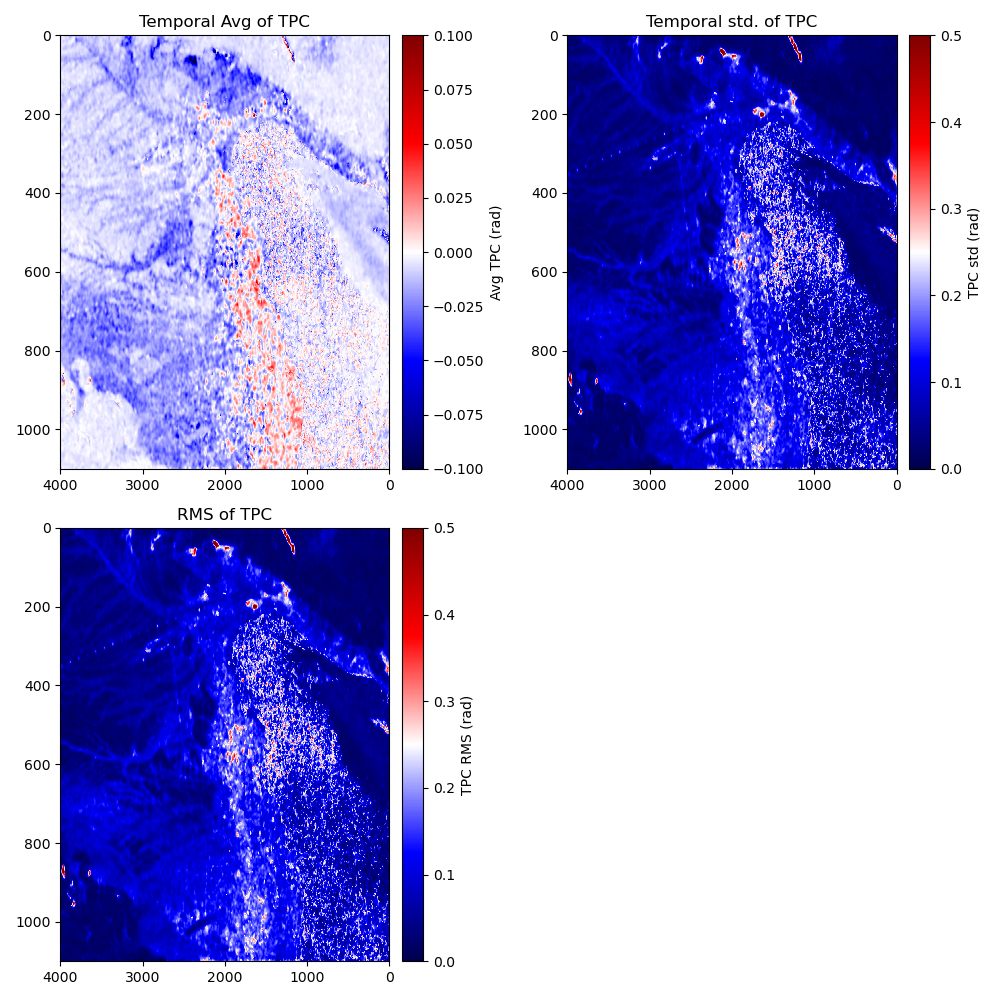

In [8]:
plt.figure(figsize=(10,10),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(avg_TPCs,aspect='auto',interpolation='nearest',vmin=-0.1,vmax=0.1)
plt.colorbar(orientation='vertical',pad=0.03,label='Avg TPC (rad)'); plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0]) #plt.xticks([]); plt.yticks([])
#plt.xlim([20,0]); plt.ylim([20,0])
plt.title('Temporal Avg of TPC')
plt.subplot(2,2,2)
plt.imshow(std_TPCs,aspect='auto',interpolation='nearest',vmin=0,vmax=0.5)
plt.colorbar(orientation='vertical',pad=0.03,label='TPC std (rad)'); plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0]) #plt.xticks([]); plt.yticks([])
#plt.xlim([20,0]); plt.ylim([20,0])
plt.title('Temporal std. of TPC')
plt.subplot(2,2,3)
plt.imshow(rms_TPCs,aspect='auto',interpolation='nearest',vmin=0,vmax=0.5)
plt.colorbar(orientation='vertical',pad=0.03,label='TPC RMS (rad)'); plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0]) #plt.xticks([]); plt.yticks([])
#plt.xlim([20,0]); plt.ylim([20,0])
plt.title('RMS of TPC')
plt.show()

Now mask based on ALL the criteria above. Iterate over variables to be masked.

In [9]:
elev_min = -20
# elev_min = 0
# elev_max = 100 # was 75
elev_max = 250
elev_masked = np.ma.masked_outside(elev_cropped,elev_min,elev_max)
# elev_masked = np.ma.masked_where(elev_masked>elev_max,elev_masked)

th_time = 0.75
coh_time_masked = np.ma.masked_where(time_above_th<th_time,time_above_th)

# th_coh_mean = 0.88
# th_coh_mean = 0.85
th_coh_mean = 0.8
coh_mean_masked = np.ma.masked_where(coh_mean<th_coh_mean,coh_mean)

th_coh_std = 0.1
coh_std_masked = np.ma.masked_where(coh_std>th_coh_std,coh_std)

TPC_avg_th = 0.01
avg_TPC_masked = np.ma.masked_where(np.abs(avg_TPCs)>TPC_avg_th,avg_TPCs)

TPC_std_th = 0.05
std_TPC_masked = np.ma.masked_where(std_TPCs>TPC_std_th,std_TPCs)

Plot them.

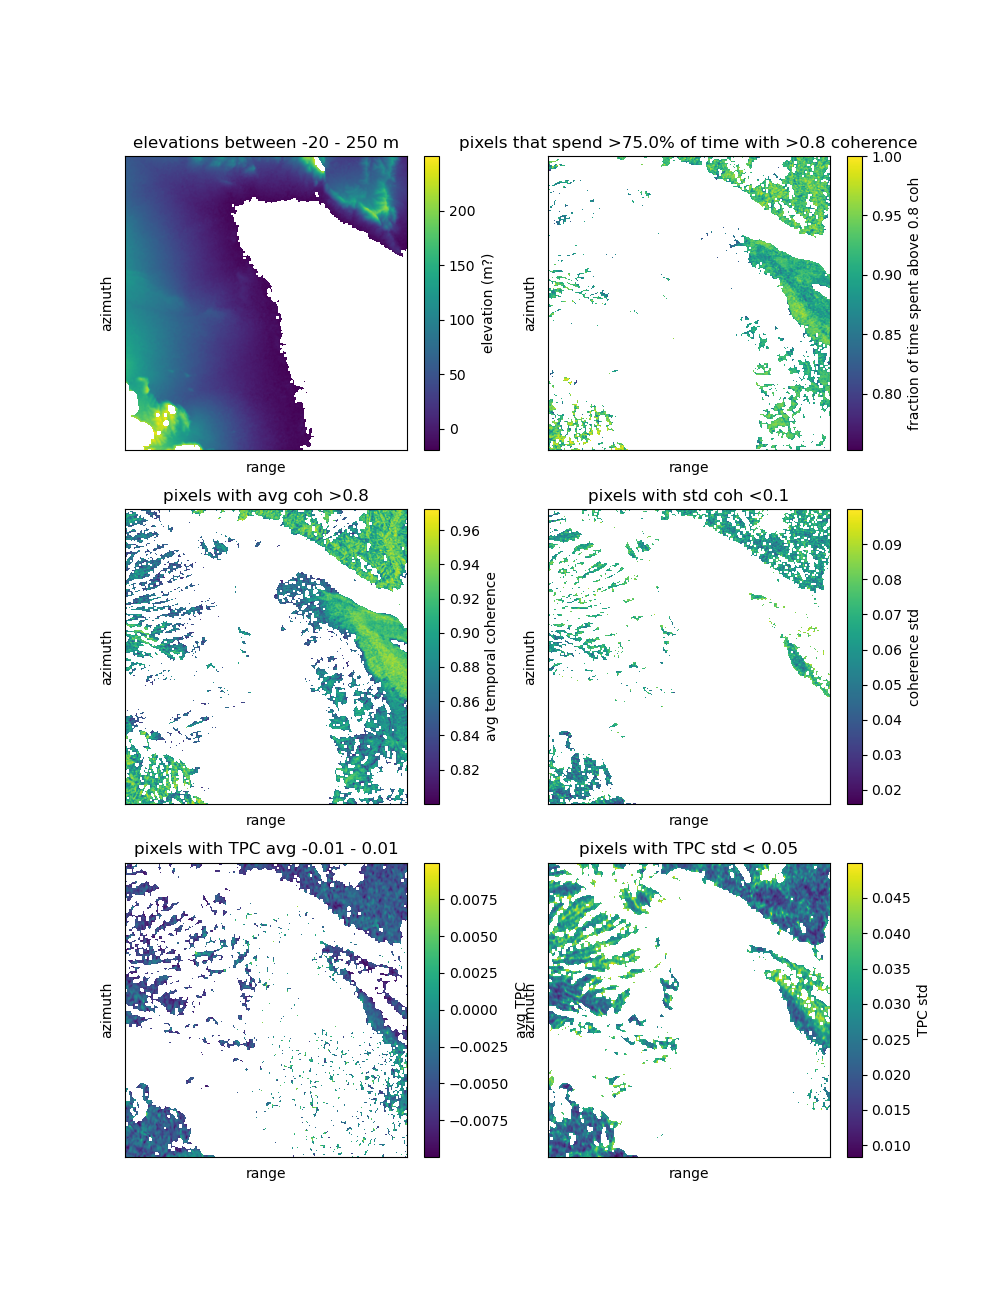

In [10]:
plt.figure(figsize=(10,13))
plt.subplot(3,2,1)
plt.imshow(elev_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('elevations between '+str(elev_min)+' - '+str(elev_max)+' m'); plt.colorbar(label='elevation (m?)')
#plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.subplot(3,2,2)
plt.imshow(coh_time_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
label_cbar = str('fraction of time spent above '+str(th_coh)+' coh')
title_text = str('pixels that spend >'+str(th_time*100)+'% of time with >'+str(th_coh)+' coherence')
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label=label_cbar)
plt.subplot(3,2,3)
plt.imshow(coh_mean_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
title_text = str('pixels with avg coh >'+str(th_coh_mean))
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label='avg temporal coherence')
plt.subplot(3,2,4)
plt.imshow(coh_std_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
title_text = str('pixels with std coh <'+str(th_coh_std))
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label='coherence std')
plt.subplot(3,2,5)
plt.imshow(avg_TPC_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
title_text = str('pixels with TPC avg -'+str(TPC_avg_th)+' - '+str(TPC_avg_th))
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label='avg TPC')
plt.subplot(3,2,6)
plt.imshow(std_TPC_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
title_text = str('pixels with TPC std < '+str(TPC_std_th))
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title(title_text); plt.colorbar(label='TPC std')
plt.show()

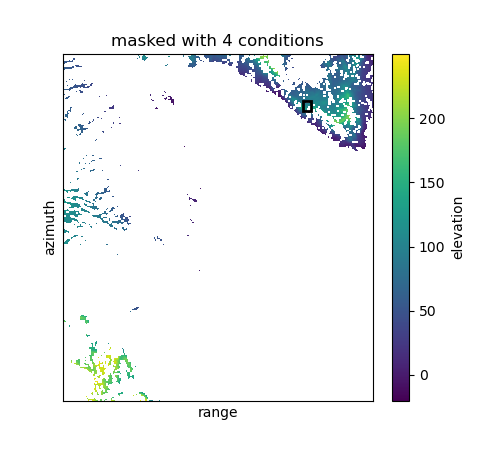

Number of reference pixels based on threshold criteria:
711798
west half has 311278.0 pixels.
east half has 400520.0 pixels.


In [16]:
# elev_min = -20
# elev_min = 0
# elev_max = 75
# elev_max = 250

# masked = np.ma.masked_where(elev_cropped<elev_min,elev_cropped)
# masked = np.ma.masked_where(masked>elev_max,masked)

elev_min = -20
elev_max = 250

# larger area with western mtns 
#masked = np.ma.masked_where(elev_ref_region==0,elev_cropped)
masked = np.ma.masked_outside(elev_cropped,elev_min,elev_max) # is this right? 
masked = np.ma.masked_where(time_above_th<th_time,masked)
masked = np.ma.masked_where(coh_mean<th_coh_mean,masked)
masked = np.ma.masked_where(coh_std>th_coh_std,masked)
masked = np.ma.masked_where(np.abs(avg_TPCs)>TPC_avg_th,masked)
masked = np.ma.masked_where(std_TPCs>TPC_std_th,masked)

plt.figure(figsize=(5,4.5))
plt.imshow(masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('masked with 4 conditions'); plt.colorbar(label='elevation')
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.show()

num_ref_pix = (masked>-10000).sum()
print('Number of reference pixels based on threshold criteria:\n'+str(num_ref_pix))
ref_mask = np.zeros((dy,dx))
masked_y,masked_x = np.nonzero(masked)
ref_mask[masked_y,masked_x] = 1.0
left_side = ref_mask[:,0:int(dx/2)].sum()
right_side = ref_mask[:,int(dx/2):dx].sum()
print('west half has '+str(left_side)+' pixels.')
print('east half has '+str(right_side)+' pixels.')

Try using this combined mask to display coherence values for single igram, but masked based on above conditions.

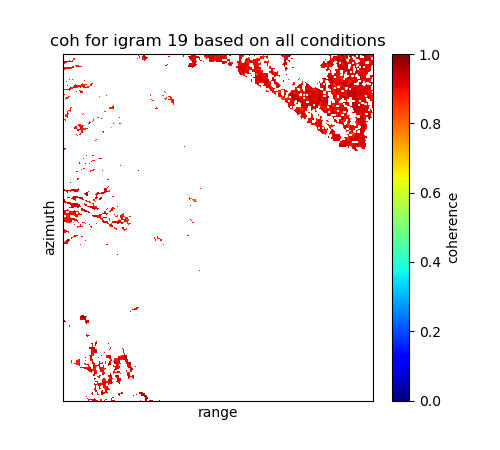

Avg coh value of ref pixels: 0.8895862976159926


In [17]:
k=19
mask_test = np.ma.masked_where(masked<-1000,coh[k])

plt.figure(figsize=(5,4.5))
plt.imshow(mask_test, cmap='jet',aspect='auto',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('coh for igram '+str(k)+' based on all conditions') 
plt.colorbar(label='coherence'); plt.show()

masked_y,masked_x = np.nonzero(masked)
ref_pix_coh_mean = np.mean(coh[k,masked_y,masked_x])
print('Avg coh value of ref pixels: '+str(ref_pix_coh_mean))

Make an array with 1's and 0's to represent the mask.

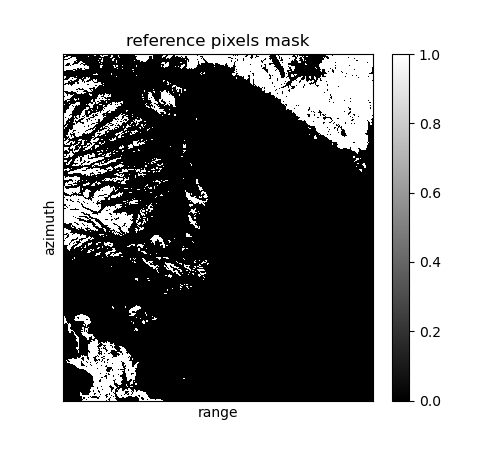

In [18]:
ref_mask = np.zeros((dy,dx))
ref_mask[masked_y,masked_x] = 1.0

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(ref_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

Now save the mask file.

In [19]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# set the folder to save this mask file to
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/'

# only needed to do this once. 
# save_file_name = 'ref_pixels_mask.r4'
# colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(ref_mask)
# colds=None
# print('Mask of reference pixels saved.')

In [20]:
print(dx,dy)

4000 1100


Check the reference pixels phase values for one igram at a time. 

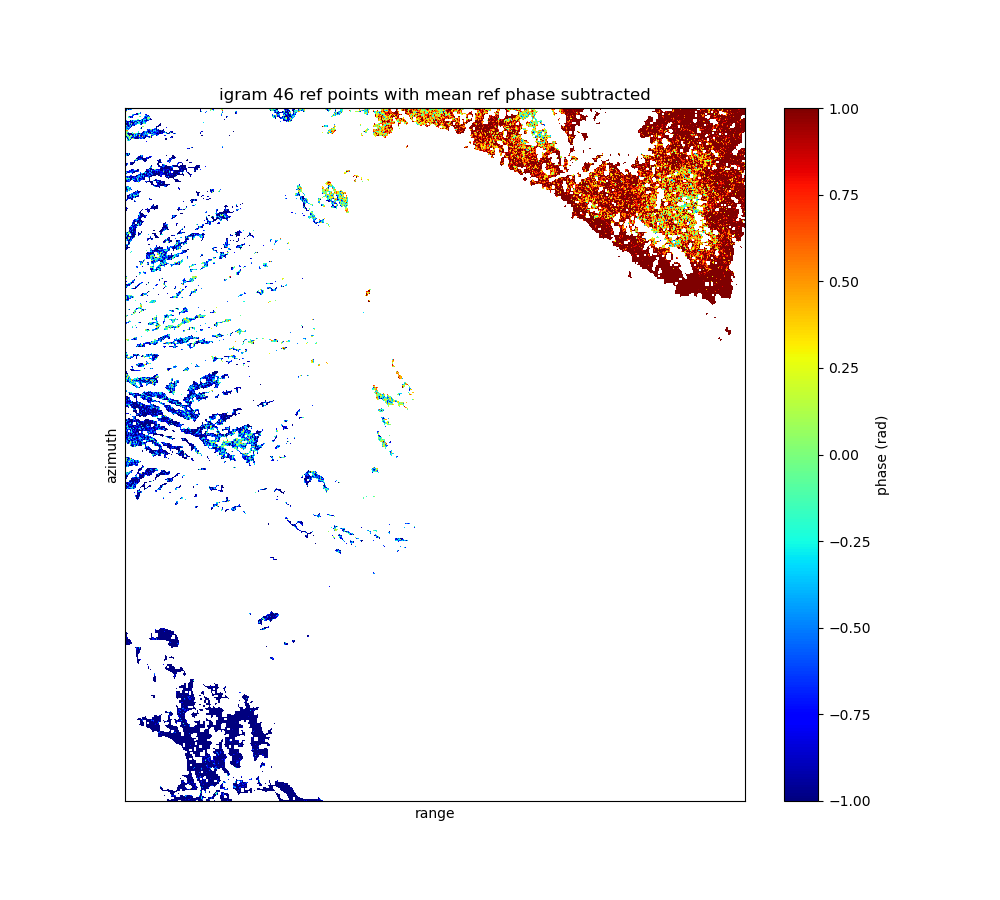

Avg phase value of ref pixels: 2.085388e-07 rad


In [21]:
k=46 # corresponds with dates
key1 = 'unfilt'

igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
igramFile = igramsDir+dates[k]+'_'+dates[k+1]+'_'+key1+'.unw'
ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
igram = igram - np.mean(igram[masked_y,masked_x])   # subtract out the reference 
igram_masked = np.ma.masked_where(ref_mask==0,igram)

plt.figure(figsize=(10,9))
plt.imshow(igram_masked, cmap='jet',aspect='auto',vmin=-1,vmax=1); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('igram '+str(k)+' ref points with mean ref phase subtracted') 
plt.colorbar(label='phase (rad)'); plt.show()

ref_pix_phs_mean = np.mean(igram[masked_y,masked_x])
print('Avg phase value of ref pixels: '+str(ref_pix_phs_mean)+' rad')